In [20]:


from pathlib import Path
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess
import multiprocessing
import nltk
from nltk.corpus import stopwords

# Téléchargement des stopwords français
nltk.download('stopwords', quiet=True)
french_stopwords = stopwords.words('french')

# Style des graphiques
plt.style.use("seaborn-v0_8")

print("=" * 70)
print("TP3 : Clustering et Word2Vec - Traitement automatique de corpus")
print("=" * 70)




TP3 : Clustering et Word2Vec - Traitement automatique de corpus


In [21]:

CORPUS_PATH = Path("/Users/walazerelli/tac-25-26/data/txt")

def load_documents(path=CORPUS_PATH):
    rows = []
    for p in path.rglob("*.txt"):
        try:
            text = p.read_text(encoding="utf-8")
        except:
            text = p.read_text(encoding="latin-1")
        year_search = re.search(r"(18|19|20)\d{2}", p.stem)
        year = int(year_search.group(0)) if year_search else 0
        rows.append({"id": p.stem, "year": year, "text": text})
    df = pd.DataFrame(rows)
    df["year"] = df["year"].fillna(0).astype(int)
    return df

df = load_documents()
print(f"\n✅ Nombre total de documents chargés : {len(df)}")

# Choix de la décennie
DECADE = (1910, 1919)
start, end = DECADE
df_dec = df[(df["year"] >= start) & (df["year"] <= end)].copy()
print(f"✅ Décennie sélectionnée : {start}-{end}")
print(f"✅ Nombre de documents dans cette décennie : {len(df_dec)}")



✅ Nombre total de documents chargés : 7937
✅ Décennie sélectionnée : 1910-1919
✅ Nombre de documents dans cette décennie : 700


In [22]:

def preprocess(text):
    """Nettoie et normalise le texte"""
    text = text.lower()
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"[^a-zàâéèêëîïôûùüçœæ\s-]", " ", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df_dec["clean"] = df_dec["text"].astype(str).apply(preprocess)
print("\n✅ Prétraitement terminé")
print("\nAperçu des textes nettoyés :")
print(df_dec["clean"].head(2))



✅ Prétraitement terminé

Aperçu des textes nettoyés :
16    sa a les fusillés de ftelcroi de notre cormpon...
29    le soir übosch ast tffffttïée dans son lit si ...
Name: clean, dtype: object



CLUSTERING DES DOCUMENTS

✅ Matrice TF-IDF créée : (700, 20000)
   → 700 documents
   → 20000 termes uniques

📊 Test de différents nombres de clusters...
   K=3 : Silhouette = 0.217
   K=4 : Silhouette = 0.195
   K=5 : Silhouette = 0.191
   K=6 : Silhouette = 0.197
   K=7 : Silhouette = 0.156
   K=8 : Silhouette = 0.152
   K=9 : Silhouette = 0.135


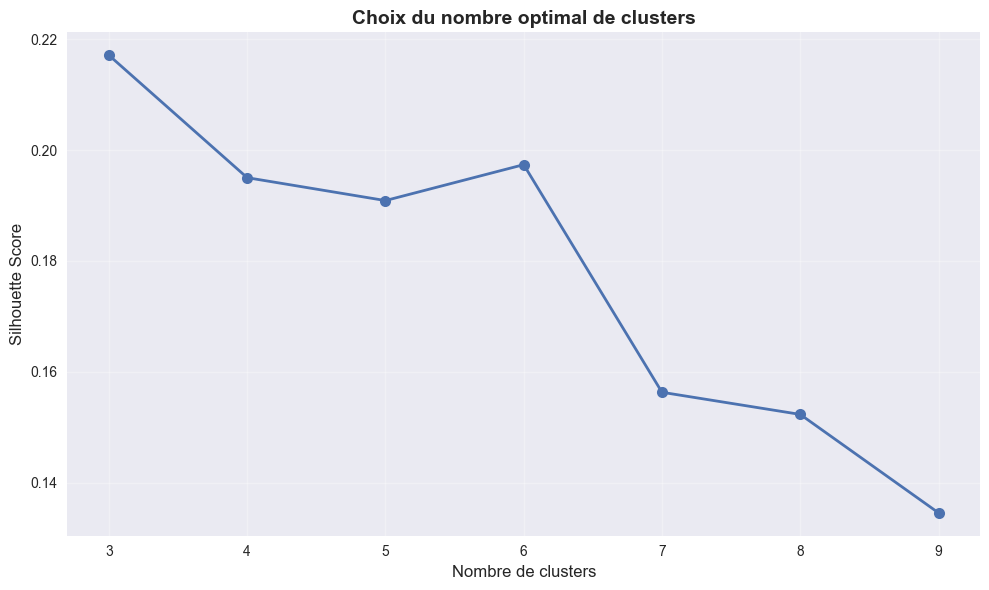

In [34]:

MAX_FEATURES = 20000
MIN_DF = 5
RANDOM_STATE = 42

print("\n" + "=" * 70)
print("CLUSTERING DES DOCUMENTS")
print("=" * 70)

tfidf = TfidfVectorizer(
    max_features=MAX_FEATURES, 
    min_df=MIN_DF, 
    stop_words=french_stopwords
)
X = tfidf.fit_transform(df_dec["clean"])
print(f"\n✅ Matrice TF-IDF créée : {X.shape}")
print(f"   → {X.shape[0]} documents")
print(f"   → {X.shape[1]} termes uniques")

# ===== TEST DU NOMBRE OPTIMAL DE CLUSTERS =====
print("\n📊 Test de différents nombres de clusters...")
silhouette_scores = []
K_range = range(3, 10)

for k in K_range:
    km_temp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=20)
    labels_temp = km_temp.fit_predict(X)
    sil_temp = silhouette_score(X, labels_temp)
    silhouette_scores.append(sil_temp)
    print(f"   K={k} : Silhouette = {sil_temp:.3f}")

# Visualisation
plt.figure(figsize=(10, 6))
plt.plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8)
plt.xlabel("Nombre de clusters", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)
plt.title("Choix du nombre optimal de clusters", fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [24]:

N_CLUSTERS = 6

kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=RANDOM_STATE, n_init=20)
labels = kmeans.fit_predict(X)
df_dec["cluster"] = labels
sil = silhouette_score(X, labels)

print(f"\n✅ Modèle final avec K={N_CLUSTERS}")
print(f"✅ Silhouette Score : {sil:.3f}")


cluster_info = df_dec.groupby("cluster").agg({
    "id": "count",
    "year": ["min", "max", "mean"]
}).round(1)
cluster_info.columns = ["Nb_docs", "Année_min", "Année_max", "Année_moy"]

print("\n" + "=" * 70)
print("DISTRIBUTION DES CLUSTERS")
print("=" * 70)
print(cluster_info)

# Sauvegarde
output_path = Path("/Users/walazerelli/tac-25-26/tp3")
output_path.mkdir(exist_ok=True)
cluster_info.to_csv(output_path / "cluster_stats.csv")
print(f"\n✅ Statistiques sauvegardées : {output_path / 'cluster_stats.csv'}")



✅ Modèle final avec K=6
✅ Silhouette Score : 0.258

DISTRIBUTION DES CLUSTERS
         Nb_docs  Année_min  Année_max  Année_moy
cluster                                          
0            103       1910       1919     1914.5
1            365       1910       1919     1914.0
2             73       1910       1919     1913.7
3             36       1910       1918     1912.1
4             24       1910       1919     1915.0
5             99       1910       1919     1913.1

✅ Statistiques sauvegardées : /Users/walazerelli/tac-25-26/tp3/cluster_stats.csv


In [25]:

print("\n" + "=" * 70)
print("TOP TERMES PAR CLUSTER")
print("=" * 70)

terms = tfidf.get_feature_names_out()
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

top_terms = {}
for i in range(N_CLUSTERS):
    top = [terms[idx] for idx in order_centroids[i, :20]]
    top_terms[i] = top
    print(f"\n🔹 Cluster {i} ({len(df_dec[df_dec['cluster']==i])} documents) :")
    print("   " + ", ".join(top[:15]))



TOP TERMES PAR CLUSTER

🔹 Cluster 0 (103 documents) :
   dem, de, et, rue, la, on, do, ou, fr, rossel, pour, pl, du, ag, fille

🔹 Cluster 1 (365 documents) :
   de, la, et, le, les, des, en, du, un, que, il, est, une, qui, au

🔹 Cluster 2 (73 documents) :
   de, louer, et, rue, dem, fr, la, ou, pl, av, rossel, du, pour, on, ag

🔹 Cluster 3 (36 documents) :
   de, et, la, le, les, en, fr, du, esp, cap, pr, des, ord, div, il

🔹 Cluster 4 (24 documents) :
   de, et, notaire, la, notaires, rue, du, do, en, contenant, le, maison, etude, ventes, bruxelles

🔹 Cluster 5 (99 documents) :
   de, fr, et, rue, la, vend, en, vendre, du, rossel, do, prix, hp, ag, des


In [26]:

print("\n" + "=" * 70)
print("EXEMPLES DE DOCUMENTS PAR CLUSTER")
print("=" * 70)

for c in range(N_CLUSTERS):
    nb_docs = len(df_dec[df_dec['cluster']==c])
    print(f"\n--- Cluster {c} ({nb_docs} documents) ---")
    sample_docs = df_dec[df_dec["cluster"] == c].head(3)
    for idx, row in sample_docs.iterrows():
        preview = row["text"][:200].replace("\n", " ")
        print(f"  • [{row['id']}] {preview}...")



EXEMPLES DE DOCUMENTS PAR CLUSTER

--- Cluster 0 (103 documents) ---
  • [KB_JB838_1918-12-09_01-00002] sa». a' Les fusillés de ftelcroi (De notre cormponrtant particulier.) Pendant 1’oecupstion allemande plusieurs personnes furect fusillés à Cnarlerol. . Caj exécutions, avaient lieu au petit jour, le l...
  • [KB_JB838_1912-09-20_01-00007] nTodas Ou item. Wÿrt- et apprentles.-- jm. f lûter.Æant. 6317 TvJ (jeiu une apprentie Il (aÜx^o^o et des demi* /mvrières mmatee. 34. jr. ^TKlill 84. as 1 »*» râîSTtwue maison do glos comptable, libre ...
  • [KB_JB838_1913-10-22_01-00007] « ocTumœ ms' l'B *S O IK i /'ihavffsurménmlelsn, 99 Ajtsas, pari. ang!..franc. «an)., dés. place, maison îprîÿêe,environs Bruxelles, présente par parents. R. Copin»'Mon Rêve, Leffin- ghe lei-Ostenûo. ...

--- Cluster 1 (365 documents) ---
  • [KB_JB838_1914-03-19_01-00005] 3 LE SOIR ^übosch ast.tffffttïée dans son lit. Si la pluie ÿp. de tt®£iî)èr pefidaritün jour ou deux,* les A Kâmur . femme exprimer mes - senti


📊 Génération des wordclouds...


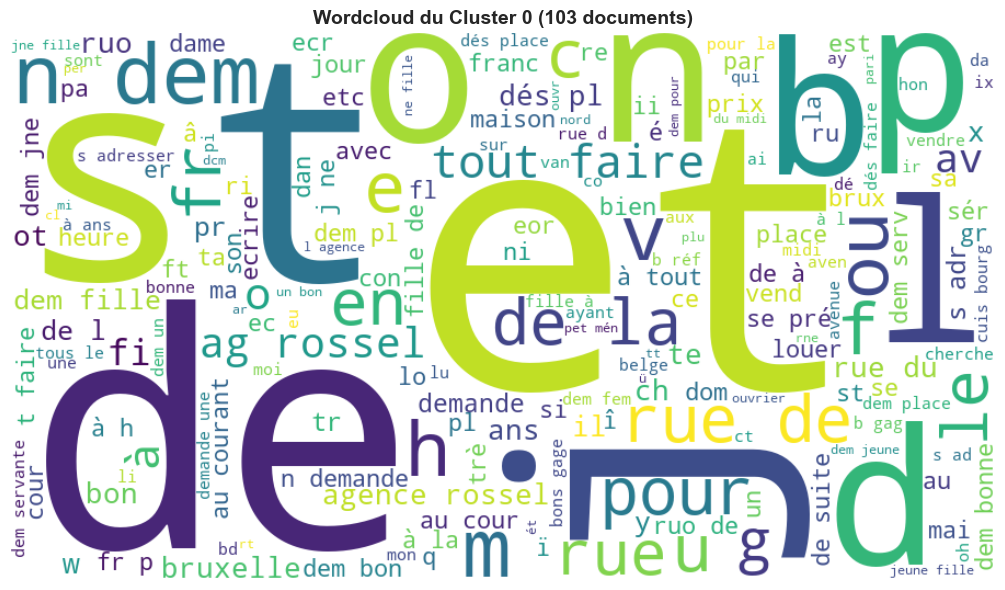

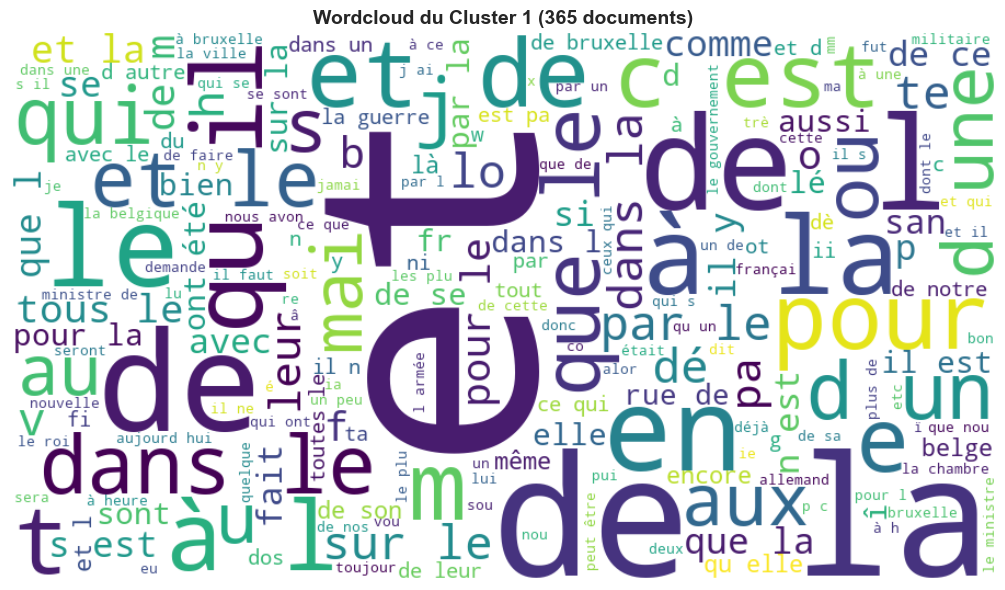

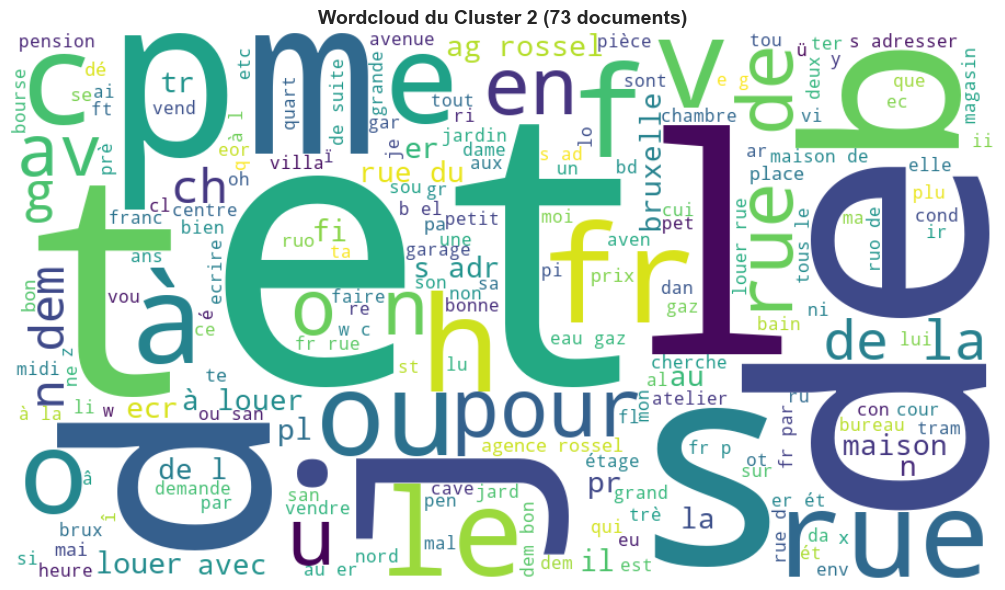

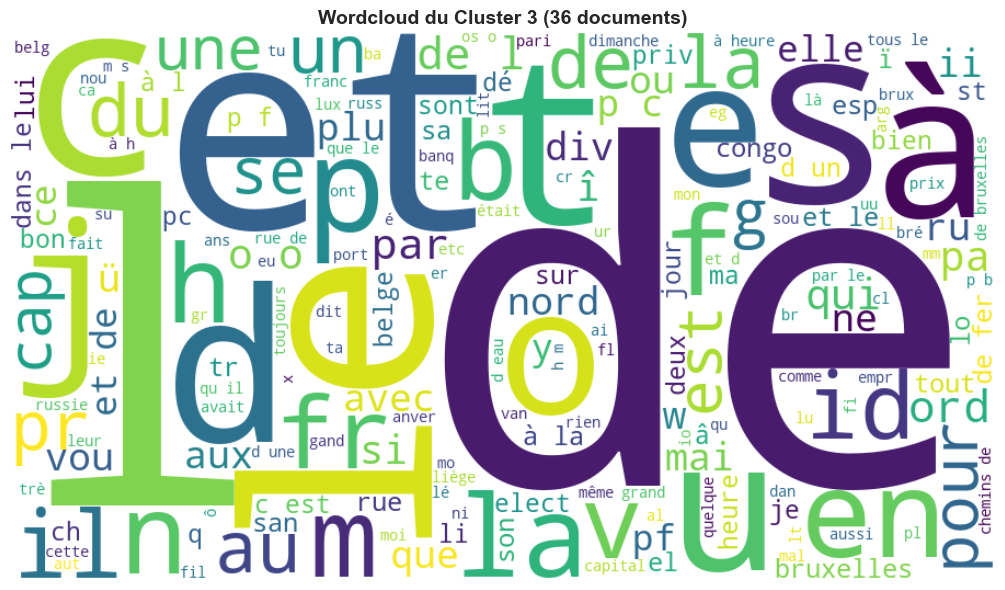

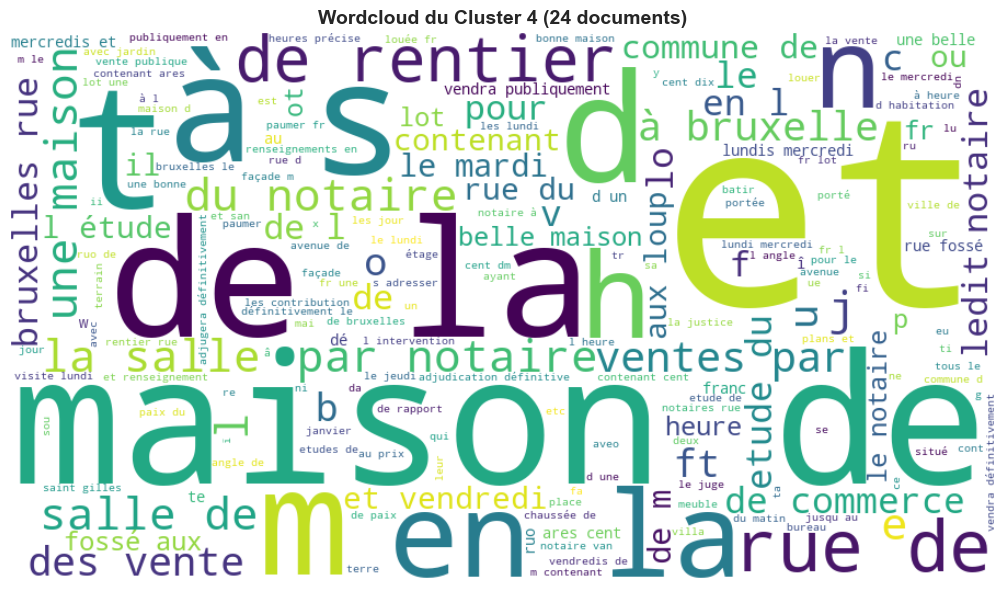

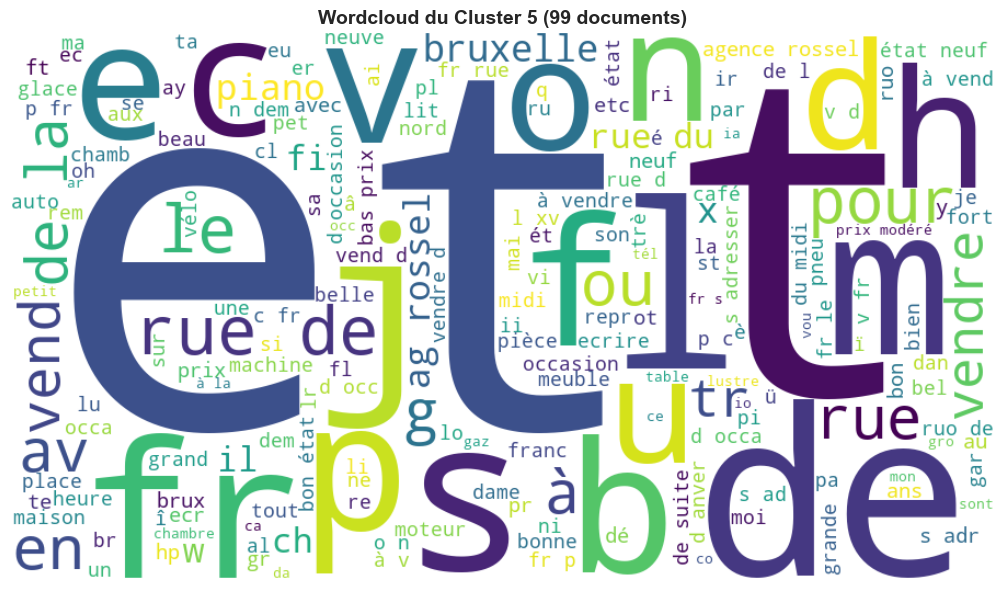


✅ Wordclouds générés


In [27]:

print("\n📊 Génération des wordclouds...")

for c in range(N_CLUSTERS):
    subset = " ".join(df_dec[df_dec["cluster"] == c]["clean"])
    if not subset.strip():
        print(f"⚠️  Cluster {c} : pas de texte disponible")
        continue
    
    wc = WordCloud(
        width=900, 
        height=500, 
        background_color="white",
        colormap="viridis"
    ).generate(subset)
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Wordcloud du Cluster {c} ({len(df_dec[df_dec['cluster']==c])} documents)", 
              fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print("\n✅ Wordclouds générés")


In [30]:

print("\n" + "=" * 70)
print("WORD2VEC - WORD EMBEDDINGS")
print("=" * 70)

SENTS_PATH = "/Users/walazerelli/tac-25-26/data/txt/sents.txt"

path_obj = Path(SENTS_PATH)
if not path_obj.exists():
    raise FileNotFoundError(f"❌ Le fichier sents.txt est introuvable : {SENTS_PATH}")

sentences = []
with open(path_obj, "r", encoding="utf-8") as f:
    for line in f:
        tokens = simple_preprocess(line.strip(), deacc=True)
        if tokens:
            sentences.append(tokens)

print(f"\n✅ Phrases chargées : {len(sentences)}")
print(f"✅ Exemple de phrase tokenisée : {sentences[0][:10]}...")



WORD2VEC - WORD EMBEDDINGS

✅ Phrases chargées : 966392
✅ Exemple de phrase tokenisée : ['mi', 'imnri', 'hmu', 'tx', 'marche', 'tenu', 'hors', 'villa', 'la']...


In [31]:

W2V_SIZE = 200
W2V_WORKERS = max(1, multiprocessing.cpu_count() - 1)
RANDOM_STATE = 42

print("\n📊 Test de différentes configurations Word2Vec...")
configs = [
    {"window": 3, "min_count": 3},
    {"window": 5, "min_count": 5},
    {"window": 10, "min_count": 2}
]

results = []
for config in configs:
    print(f"\n   → Entraînement avec window={config['window']}, min_count={config['min_count']}...", end=" ")
    m = Word2Vec(
        sentences, 
        vector_size=W2V_SIZE, 
        workers=W2V_WORKERS,
        window=config["window"], 
        min_count=config["min_count"], 
        seed=RANDOM_STATE, 
        epochs=5
    )
    vocab_size = len(m.wv)
    results.append({
        "window": config['window'],
        "min_count": config['min_count'],
        "vocab_size": vocab_size
    })
    print(f"Vocabulaire : {vocab_size} mots")

# Tableau comparatif
comparison_df = pd.DataFrame(results)
print("\n" + "=" * 70)
print("COMPARAISON DES PARAMÈTRES")
print("=" * 70)
print(comparison_df.to_string(index=False))



📊 Test de différentes configurations Word2Vec...

   → Entraînement avec window=3, min_count=3... 

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulaire : 98546 mots

   → Entraînement avec window=5, min_count=5... 

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulaire : 64099 mots

   → Entraînement avec window=10, min_count=2... 

Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'


Vocabulaire : 163112 mots

COMPARAISON DES PARAMÈTRES
 window  min_count  vocab_size
      3          3       98546
      5          5       64099
     10          2      163112


In [32]:

print("\n" + "=" * 70)
print("ENTRAÎNEMENT DU MODÈLE FINAL")
print("=" * 70)

W2V_WINDOW = 5
W2V_MIN_COUNT = 5

model = Word2Vec(
    sentences=sentences,
    vector_size=W2V_SIZE,
    window=W2V_WINDOW,
    min_count=W2V_MIN_COUNT,
    workers=W2V_WORKERS,
    seed=RANDOM_STATE,
    epochs=5
)

model_path = Path("/Users/walazerelli/tac-25-26/data/word2vec.model")
model.save(str(model_path))
print(f"\n✅ Modèle Word2Vec sauvegardé : {model_path}")
print(f"✅ Taille du vocabulaire : {len(model.wv)} mots")



ENTRAÎNEMENT DU MODÈLE FINAL


Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'
Exception ignored in: 'gensim.models.word2vec_inner.our_dot_float'



✅ Modèle Word2Vec sauvegardé : /Users/walazerelli/tac-25-26/data/word2vec.model
✅ Taille du vocabulaire : 64099 mots


In [33]:

print("\n" + "=" * 70)
print("EXPLORATION DU MODÈLE WORD2VEC")
print("=" * 70)

# Rechargement du modèle
model = Word2Vec.load(str(model_path))


pairs = [("roi", "reine"), ("guerre", "armée"), ("père", "mère")]
print("\n📐 SIMILARITÉS ENTRE MOTS :")
for a, b in pairs:
    try:
        sim = model.wv.similarity(a, b)
        print(f"   {a:15s} ↔ {b:15s} : {sim:.3f}")
    except KeyError as e:
        print(f"   {a:15s} ↔ {b:15s} : [mot absent: {e}]")

# 2. MOTS LES PLUS PROCHES
words = ["guerre", "amour", "roi"]
print("\n🔍 MOTS LES PLUS PROCHES :")
for w in words:
    try:
        print(f"\n   Top 5 mots proches de '{w}' :")
        for sim_word, score in model.wv.most_similar(w, topn=5):
            print(f"      • {sim_word:20s} ({score:.3f})")
    except KeyError:
        print(f"\n   '{w}' : [mot absent du vocabulaire]")

# 3. ANALOGIES VECTORIELLES
print("\n🧮 ANALOGIES (A - B + C = ?) :")
analogies = [
    ("roi", "homme", "femme"),
    ("paris", "france", "allemagne"),
    ("grand", "petit", "long")
]

for positive1, negative, positive2 in analogies:
    try:
        result = model.wv.most_similar(
            positive=[positive1, positive2], 
            negative=[negative], 
            topn=1
        )
        print(f"   {positive1} - {negative} + {positive2} = {result[0][0]} ({result[0][1]:.3f})")
    except KeyError as e:
        print(f"   {positive1} - {negative} + {positive2} = [mot absent: {e}]")

print("\n" + "=" * 70)
print("✅ TP3 TERMINÉ")
print("=" * 70)



EXPLORATION DU MODÈLE WORD2VEC

📐 SIMILARITÉS ENTRE MOTS :
   roi             ↔ reine           : 0.547
   guerre          ↔ armée           : [mot absent: "Key 'armée' not present"]
   père            ↔ mère            : [mot absent: "Key 'père' not present"]

🔍 MOTS LES PLUS PROCHES :

   Top 5 mots proches de 'guerre' :
      • defense              (0.719)
      • marine               (0.708)
      • republique           (0.695)
      • grece                (0.686)
      • population           (0.683)

   Top 5 mots proches de 'amour' :
      • esprit               (0.780)
      • orgueil              (0.776)
      • reve                 (0.757)
      • cœur                 (0.745)
      • sentiment            (0.744)

   Top 5 mots proches de 'roi' :
      • prince               (0.769)
      • tsar                 (0.746)
      • pape                 (0.727)
      • sultan               (0.709)
      • duc                  (0.673)

🧮 ANALOGIES (A - B + C = ?) :
   roi - homme + f